# Modeling: Predicting Food Affordability

## RQ2: Does affordability_ratio's mean differ across different regions, geotypes, and income levels? 

In order to test this, I will be using a one-way ANOVA test. Since I have three different variables where I want to see if the different groups within the variables change the mean of affordability ratio, I'll be running the ANOVA 3 times. Then, I'll be using Tukey HSD to run post-hoc testing given we reject the null hypothesis within the ANOVA. Even though we have right-skewedness, ANOVA is still reasonable because of our large sample size and the robustness of ANOVA to deviations from normality. We assume that observations are independent and that variance is homogeneous.

For this test, my null hypothesis is that affordability_ratio's mean does not differ acoss different regions, different geotypes, and different income levels. Written out for region, geotype, and income level:

Region
Null: The mean of affordability_ratio does not differ across different groups of region.
Alternative: At least one mean of affordability_ratio differs from others across different groups of region.

Geotype
Null: The mean of affordability_ratio does not differ across different groups of geotype.
Alternative: At least one mean of affordability_ratio differs from others across different groups of geotype.

Income Level
Null: The mean of affordability_ratio does not differ across different groups of income level.
Alternative: At least one mean of affordability_ratio differs from others across different groups of income level.

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

df_2 = pd.read_csv(DATA_PATH)
df_2.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,se_food_afford,rse_food_afford,food_afford_decile,CA_RR_Affordability,ave_fam_size,version
0,757,Food affordability for female-headed household...,2006-2010,1.0,AIAN,CA,6.0,California,NaN,NaN,...,23777.0,0.315779,0.231517,0.400043,0.042991,13.614342,NaN,1.185347,3.34,4/12/2013 4:33
1,757,Food affordability for female-headed household...,2006-2010,2.0,Asian,CA,6.0,California,NaN,NaN,...,38508.0,0.194980,0.183065,0.206895,0.006079,3.117814,NaN,0.731900,3.34,4/12/2013 4:33
2,757,Food affordability for female-headed household...,2006-2010,3.0,AfricanAm,CA,6.0,California,NaN,NaN,...,26192.0,0.286664,0.279661,0.293666,0.003573,1.246349,NaN,1.076054,3.34,4/12/2013 4:33
3,757,Food affordability for female-headed household...,2006-2010,4.0,Latino,CA,6.0,California,NaN,NaN,...,22858.0,0.328475,0.322637,0.334314,0.002979,0.906881,NaN,1.233004,3.34,4/12/2013 4:33
4,757,Food affordability for female-headed household...,2006-2010,5.0,NHOPI,CA,6.0,California,NaN,NaN,...,36737.0,0.204379,0.173762,0.234997,0.015621,7.643255,NaN,0.767183,3.34,4/12/2013 4:33


In [6]:
# Slecting only necessary columns
# I also dropped large outliers to reduce the skewedness slightly
rq2_cols = ["affordability_ratio", "median_income", "region_name", "geotype"]
df_rq2 = df_2[rq2_cols].copy()
df_rq2 = df_rq2.dropna(subset=["affordability_ratio", "median_income", "region_name", "geotype"])
upper = df_rq2["affordability_ratio"].quantile(0.99)
df_rq2 = df_rq2[df_rq2["affordability_ratio"] <= upper].copy()

df_rq2.shape

df_rq2["income_group"] = pd.qcut(
    df_rq2["median_income"],
    q=4,
    labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
)

df_rq2["income_group"].value_counts()
df_rq2.groupby("income_group")["median_income"].mean()
df_rq2.groupby("income_group")["affordability_ratio"].mean()

/tmp/ipykernel_214/492765943.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_rq2.groupby("income_group")["median_income"].mean()
/tmp/ipykernel_214/492765943.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_rq2.groupby("income_group")["affordability_ratio"].mean()


income_group
Q1 (Lowest)     0.684877
Q2              0.303270
Q3              0.202455
Q4 (Highest)    0.116724
Name: affordability_ratio, dtype: float64

In [7]:
def one_way_anova(df, target, group, min_group_size=5):
    grouped = df[[target, group]].dropna().groupby(group)
    samples = [g[target].values for _, g in grouped if len(g) >= min_group_size]
    if len(samples) < 2:
        raise ValueError(f"Need at least 2 groups with >= {min_group_size} samples for ANOVA.")
    F, p = f_oneway(*samples)
    n_groups = len(samples)
    n_total = sum(len(s) for s in samples)
    return {"F": float(F), "p_value": float(p), "n_groups": n_groups, "n_total": n_total}


# This is for post-hoc testing given we reject the null hypothesis for the one-way ANOVA test. In that case, I'll be running the Tukey HSD with a standard significance level of 0.05 - but the alpha level can also be changed.
def tukey_hsd(df, target, group, alpha=0.05):
    sub = df[[target, group]].dropna()
    tukey = pairwise_tukeyhsd(endog=sub[target], groups=sub[group], alpha=alpha)
    return pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])

## ANOVA for Regions

In [8]:
# ANOVA for region
anova_region = one_way_anova(df_rq2, target="affordability_ratio", group="region_name")
anova_region

{'F': 19.996761859495177,
 'p_value': 2.538578935644317e-49,
 'n_groups': 15,
 'n_total': 3439}

My F-statistic for this test was 19.996, which leads me to a p-value of 2.54 times e^-49. This very small p-value leads me to reject the null hypothesis and we conclude that there is statistically significant evidence that at least one regional mean affordability ratio differs from the others.

Now, I will run post-hoc testing with Tukey HSD.

In [9]:
# Tukey for region
tukey_region = tukey_hsd(df_rq2, "affordability_ratio", "region_name")
tukey_region.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Bay Area,Butte,0.1848,0.0066,0.0266,0.3430,True
1,Bay Area,California,0.0164,1.0000,-0.3487,0.3815,False
2,Bay Area,Central/Southeast Sierra,0.1299,0.0663,-0.0036,0.2633,False
3,Bay Area,Monterey Bay,0.1557,0.0000,0.0546,0.2568,True
4,Bay Area,North Coast,0.1623,0.0000,0.0542,0.2704,True


Tukey HSD results indicate that the Bay Area exhibits significantly higher food affordability ratio than other inland regions like Butte, Monterey Bay, and North Coast. The reason we know that Bay Area food affordability ratio is larger is because the mean differences are positives with a low p-val. This shows a greater food cost burden in coastal regions.

## ANOVA for Geotype

In [10]:
# ANOVA for geotype
anova_geotype = one_way_anova(df_rq2, target="affordability_ratio", group="geotype")
anova_geotype

{'F': 0.2205838707762331,
 'p_value': 0.8821537113878416,
 'n_groups': 4,
 'n_total': 3439}

My F-statistic for this test was 0.22, which leads me to a p-value of 0.88. This large p-value leads me to fail to reject the null hypothesis and we conclude that there is no statistically significant evidence that at least one regional mean affordability ratio differs from the others.

I will not run post-hoc testing with Tukey HSD in this case.

## ANOVA for Income Level

In [11]:
# ANOVA for income level
anova_income_level = one_way_anova(df_rq2, target="affordability_ratio", group="income_group")
anova_income_level

/tmp/ipykernel_214/1154432867.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df[[target, group]].dropna().groupby(group)


{'F': 850.1216693204053, 'p_value': 0.0, 'n_groups': 4, 'n_total': 3439}

My F-statistic for this test was 850.12, which leads me to a p-value of 0.0. This very small p-value leads me to reject the null hypothesis and we conclude that there is statistically significant evidence that at least one regional mean affordability ratio differs from the others.

Now, I will run post-hoc testing with Tukey HSD.

In [12]:
# Tukey for income level
tukey_income_level = tukey_hsd(df_rq2, "affordability_ratio", "income_group")
tukey_income_level.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Q1 (Lowest),Q2,-0.3816,0.0,-0.4129,-0.3504,True
1,Q1 (Lowest),Q3,-0.4824,0.0,-0.5137,-0.4512,True
2,Q1 (Lowest),Q4 (Highest),-0.5682,0.0,-0.5994,-0.5369,True
3,Q2,Q3,-0.1008,0.0,-0.1321,-0.0695,True
4,Q2,Q4 (Highest),-0.1865,0.0,-0.2178,-0.1553,True


Post-hoc with Tukey HSD shows there are statistically significant differences in mean food affordability ratios throughout Q1, Q2, Q3, and Q4. Even though affordability ratios increase as you go from Q1 to Q4, every higher income group shows a larger food cost burden than the group before it. The higher income regions show higher affordability ratios, which might suggest that food costs are disproportionately increasing with income level across Californian regions.

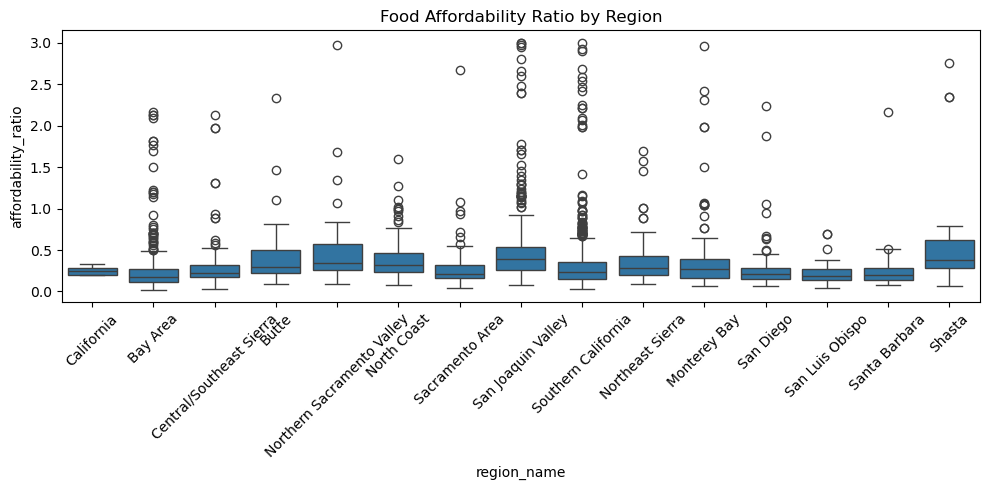

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_rq2,
    x="region_name",
    y="affordability_ratio"
)
plt.xticks(rotation=45)
plt.title("Food Affordability Ratio by Region")
plt.tight_layout()
plt.show()

This figure shows the spread of food affordability raito by region.

## Conclusion for RQ2

For this question, I aimed to look at potential differences in mean of affordability ratio in region, income level, and geotype. I concluded that there were signficiant differences in mean between region and income level, but not geotype.

# RQ3: How can we visualize the relationship between income and food affordability by region?

To answer this quesiton, I'll be looking into an interaction model using affordability_ratio ~ median_income x region_name

Assumptions and Limitations for this question:
I'll be fitting an OLS interaction model that tests if median income and affordability ratio's relationship differs by region. Since this is an obersvational and aggregated dataset, the results I get will be descriptive based on the data and not causal. Also, since this dataset is aggregated, the results I get could be more smoothed and have less variation than if I had a bunch of much mroe raw data.

OLS assumes independent observations, linear relationship, and homoskedasticity. Because the affordability ratio is right-skewed as mentioned before and the model may not extrapolate well, I restricted the interaction plot to the smaller range as described in the code below, which is 5th to 95th percentile.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# For preprocessing, I only kept the top 6 regions. I did the same with the getting rid of large outliers as RQ2.
df_rq3 = df_2[["affordability_ratio", "median_income", "region_name"]].dropna().copy()
upper = df_rq3["affordability_ratio"].quantile(0.99)
df_rq3 = df_rq3[df_rq3["affordability_ratio"] <= upper].copy()
df_rq3["income_c"] = df_rq3["median_income"] - df_rq3["median_income"].mean()
TOP_N = 6
top_regions = df_rq3["region_name"].value_counts().head(TOP_N).index
df_rq3_plot = df_rq3[df_rq3["region_name"].isin(top_regions)].copy()

df_rq3_plot["region_name"] = df_rq3_plot["region_name"].astype("category")


model_int = smf.ols(
    "affordability_ratio ~ income_c * C(region_name)",
    data=df_rq3_plot
).fit()

print(model_int.summary())

                             OLS Regression Results                            
Dep. Variable:     affordability_ratio   R-squared:                       0.356
Model:                             OLS   Adj. R-squared:                  0.353
Method:                  Least Squares   F-statistic:                     145.6
Date:                 Sun, 14 Dec 2025   Prob (F-statistic):          4.04e-267
Time:                         21:19:01   Log-Likelihood:                -226.69
No. Observations:                 2912   AIC:                             477.4
Df Residuals:                     2900   BIC:                             549.1
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

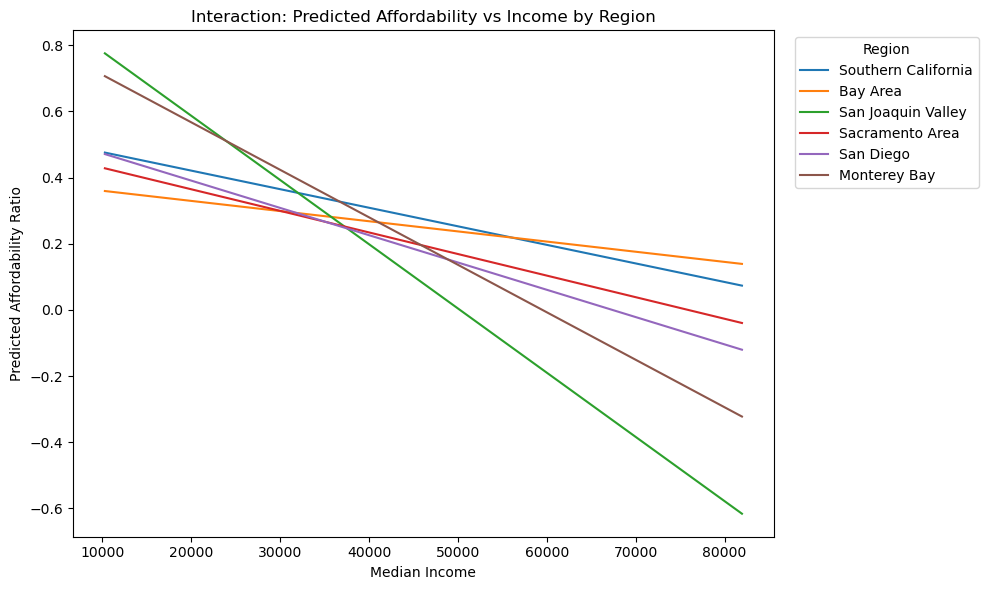

In [23]:
low, high = df_rq3_plot["median_income"].quantile([0.05, 0.95])
income_grid_raw = np.linspace(low, high, 100)

income_grid = income_grid_raw - df_rq3_plot["median_income"].mean()
pred_frames = []
for r in top_regions:
    tmp = pd.DataFrame({
        "income_c": income_grid,
        "region_name": r
    })
    tmp["pred_affordability"] = model_int.predict(tmp)
    pred_frames.append(tmp)

pred_df = pd.concat(pred_frames, ignore_index=True)
plt.figure(figsize=(10, 6))
for r in top_regions:
    sub = pred_df[pred_df["region_name"] == r]
    plt.plot(income_grid_raw, sub["pred_affordability"], label=r)
plt.xlabel("Median Income")
plt.ylabel("Predicted Affordability Ratio")
plt.title("Interaction: Predicted Affordability vs Income by Region")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [24]:
model_no_int = smf.ols(
    "affordability_ratio ~ income_c + C(region_name)",
    data=df_rq3_plot
).fit()

from statsmodels.stats.anova import anova_lm
anova_cmp = anova_lm(model_no_int, model_int)
anova_cmp

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2905.0,226.875389,0.0,NaN,NaN,NaN
1,2900.0,199.220292,5.0,27.655098,80.51367,2.472607e-79


After comparing the model that uses income + region to the interactive model, the income x region, with this statsmodel's test, we can see that there's a statistically significant improvement in fit when we use the interactive terms, since our F value is 80.5 and the p value is very small. This is significant evidence that the relationship between income and food affordability is different across regions.


### RQ3 Results (Income × Region)

As you can see in the figure, the interaction model lets the affordability ratio slope change from region to region. Compared to the additivie income + region model shows that the interaction plot improves fit significantly. The clear differences in the slopes shows that the association between income and affordability is not the same across California regions.


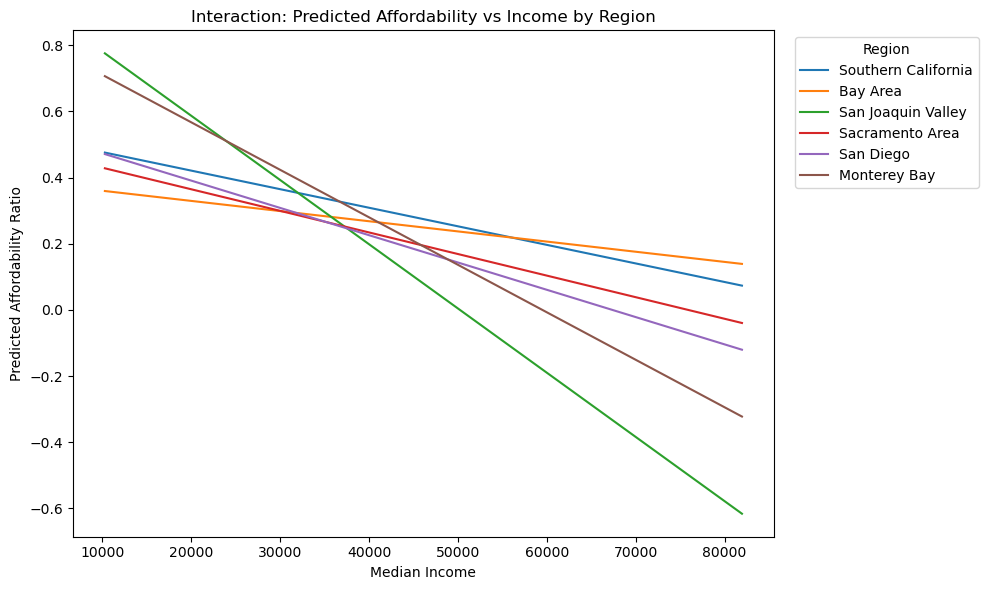

PosixPath('figures/rq3_income_region_interaction.png')

In [25]:
fig_path = FIG_DIR / "rq3_income_region_interaction.png"

plt.figure(figsize=(10, 6))
for r in top_regions:
    sub = pred_df[pred_df["region_name"] == r]
    plt.plot(sub["income_c"] + df_rq3_plot["median_income"].mean(), sub["pred_affordability"], label=r)

plt.xlabel("Median Income")
plt.ylabel("Predicted Affordability Ratio")
plt.title("Interaction: Predicted Affordability vs Income by Region")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.show()

fig_path


## RQ4: When all predictors are considered together, which variables contribute the most to predicting affordability?

Target: affordability_ratio is right-skewed, so we model log1p(affordability_ratio).
Models:
- Dummy baseline (predict mean)
- Linear regression with one-hot encoding for categorical features

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

RANDOM_STATE = 159
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("./data/food_affordability.csv")
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

In [2]:
df = pd.read_csv(DATA_PATH)

df = df[df["affordability_ratio"].notna() & df["cost_yr"].notna()].copy()

drop_cols = ["version", "ind_definition", "ind_id", "reportyear",
             "LL95_affordability_ratio", "UL95_affordability_ratio",
             "se_food_afford", "rse_food_afford",
             "county_name", "county_fips", "region_code",
             "ave_fam_size"]

df = df.drop(columns=drop_cols, errors="ignore")

df.shape

(3473, 11)

In [3]:
TARGET = "affordability_ratio"
FEATURES = ["median_income", "cost_yr", "region_name", "geotype", "race_eth_name"]

# Drop rows missing any required feature
df_model = df.dropna(subset=[TARGET] + FEATURES).copy()

X = df_model[FEATURES]
y = df_model[TARGET]

X.head(), y.describe()

(   median_income      cost_yr region_name geotype race_eth_name
 0        23777.0  7508.289655  California      CA          AIAN
 1        38508.0  7508.289655  California      CA         Asian
 2        26192.0  7508.289655  California      CA     AfricanAm
 3        22858.0  7508.289655  California      CA        Latino
 4        36737.0  7508.289655  California      CA         NHOPI,
 count    3473.000000
 mean        0.357114
 std         0.451169
 min         0.021258
 25%         0.158028
 50%         0.245429
 75%         0.381940
 max         4.852371
 Name: affordability_ratio, dtype: float64)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
cat_cols = ["region_name", "geotype", "race_eth_name"]
num_cols = ["median_income", "cost_yr"]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

In [7]:
dummy = DummyRegressor(strategy="mean")

lin = Pipeline([
    ("pre", pre),
    ("reg", LinearRegression())
])

lin_t = TransformedTargetRegressor(
    regressor=lin, func=np.log1p, inverse_func=np.expm1
)

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rows = []

# Dummy
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
rows.append({
    "model": "Dummy(mean)",
    "RMSE": rmse(y_test, pred_dummy),
    "MAE": mean_absolute_error(y_test, pred_dummy),
    "R2": r2_score(y_test, pred_dummy),
})

# Linear
lin_t.fit(X_train, y_train)
pred_lin = lin_t.predict(X_test)
rows.append({
    "model": "Linear(log1p target)",
    "RMSE": rmse(y_test, pred_lin),
    "MAE": mean_absolute_error(y_test, pred_lin),
    "R2": r2_score(y_test, pred_lin),
})

metrics = pd.DataFrame(rows).sort_values("RMSE")
metrics

,model,RMSE,MAE,R2
1,Linear(log1p target),0.340012,0.145797,0.263215
0,Dummy(mean),0.396309,0.219434,-0.000969


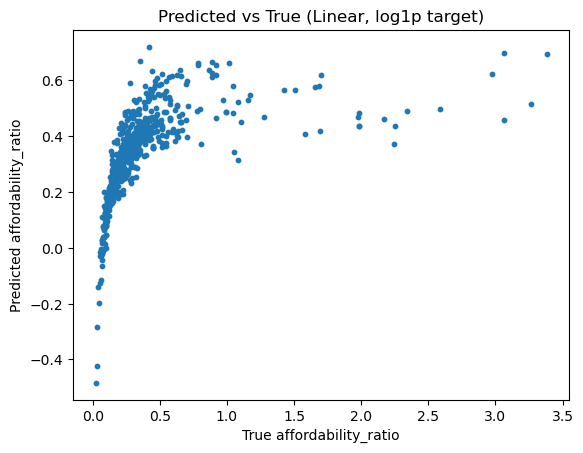

In [9]:
plt.figure()
plt.scatter(y_test, pred_lin, s=10)
plt.xlabel("True affordability_ratio")
plt.ylabel("Predicted affordability_ratio")
plt.title("Predicted vs True (Linear, log1p target)")
plt.savefig(FIG_DIR / "pred_vs_true_linear_minimal.png", dpi=150, bbox_inches="tight")
plt.show()

In [10]:
imp = permutation_importance(
    lin_t, X_test, y_test,
    n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": imp.importances_mean,
    "importance_std": imp.importances_std,
}).sort_values("importance_mean", ascending=False)

imp_df

,feature,importance_mean,importance_std
0,median_income,0.342499,0.029228
2,region_name,0.026492,0.009055
3,geotype,0.009770,0.003911
4,race_eth_name,0.002602,0.004642
1,cost_yr,-0.003561,0.006071


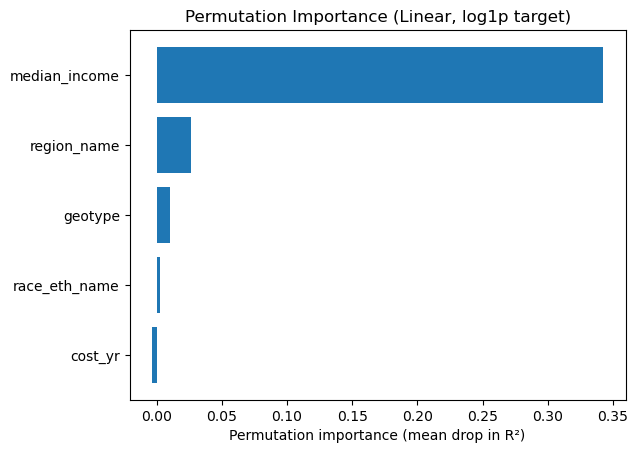

In [11]:
imp_df.to_csv(OUT_DIR / "perm_importance_linear_minimal.csv", index=False)

plt.figure()
plt.barh(imp_df["feature"][::-1], imp_df["importance_mean"][::-1])
plt.xlabel("Permutation importance (mean drop in R²)")
plt.title("Permutation Importance (Linear, log1p target)")
plt.savefig(FIG_DIR / "perm_importance_linear_minimal.png", dpi=150, bbox_inches="tight")
plt.show()